In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
t = torch.load('emobank-vad-regression-504-1.ckpt',map_location=torch.device('cpu'))


In [3]:
print(t.keys())

dict_keys(['n_updates', 'epoch', 'state_dict', 'optimizer'])


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
state_dict = t['state_dict']
optimizer = t['optimizer']

In [7]:
import json
import sys
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from transformers import (
    BertTokenizer, 
    RobertaTokenizer,
    BertModel, 
    RobertaModel, 
    BertConfig, 
    RobertaConfig
)
import argparse
from argparse import ArgumentParser

In [8]:
cache_dir = "./../ckpt/"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

model_name = 'roberta-large'
cache_path = cache_dir + model_name
if not os.path.exists(cache_path): 
    os.makedirs(cache_path + '/vocab/')
    os.makedirs(cache_path + '/model/init/')
    os.makedirs(cache_path + '/model/config/')
    
Tokenizer = RobertaTokenizer
tokenizer = Tokenizer.from_pretrained(
            model_name, 
            cache_dir=cache_path+'/vocab/')
config = RobertaConfig.from_pretrained(
        model_name, 
        cache_dir=cache_path+'/model/config/')

f = open('emobank_dim_regression.json')
args = json.load(f)
args = argparse.Namespace(**args)
config.args = args

In [9]:

from torch import nn
import torch
from transformers import *
import torch.nn.functional as F
from data.loader import SemEvalLoader, ISEARLoader, GOEMOTIONSEkmanLoader
import numpy as np


class PretrainedLMModel(BertPreTrainedModel):
    
    def __init__(self, config, cache_path, model_name):
        super(PretrainedLMModel, self).__init__(config)
        self.config = config
        self.args = config.args
        print(self.args.load_pretrained_lm_weights)

        # language models
        if self.args.load_pretrained_lm_weights:
            if self.args.model == 'bert':
                self.pre_trained_lm, loading_info = BertModel.from_pretrained(
                    model_name, 
                    cache_dir=cache_path+'/model/init/',
                    config=self.config,
                    output_loading_info=True)
            else: # 'roberta
                self.pre_trained_lm, loading_info = RobertaModel.from_pretrained(
                    model_name, 
                    cache_dir=cache_path+'/model/init/',
                    config=self.config,
                    output_loading_info=True)
            print("Model Loading Info:", loading_info)
        else:
            if self.args.model == 'bert':
                self.pre_trained_lm = BertModel(self.config)
            else: # 'roberta
                self.pre_trained_lm = RobertaModel(self.config)            

        # dropout
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.projection_lm = nn.Linear(self.config.hidden_size, self.config.vocab_size, bias=False)
        self.activation = nn.Sigmoid()

        # classification/regression head
        if self.args.task == "vad-regression":
            # baseline roberta case
            if self.args.load_ckeckpoint is False:
                self.label_num = 1
                self.loader = None
            else:
                if self.args.load_dataset=='semeval':
                    self.label_num = 11
                    self.loader = SemEvalLoader()
                elif self.args.load_dataset=='isear':
                    self.label_num = 7
                    self.loader = ISEARLoader()
                elif self.args.load_dataset=='ekman':
                    self.label_num = 7
                    self.loader = GOEMOTIONSEkmanLoader()

            self.head =nn.Linear(
                self.config.hidden_size,
                self.label_num * 3
            )

            # initialize head weight for each dimension (V,A,D)
            if self.loader is not None:
                self.category_label_names = self.loader.labels
                self.category_label_vads = self.loader.get_vad_coordinates_of_labels()
                v_scores = [self.category_label_vads[key][0] for key in self.category_label_names]
                self.v_sorted_idxs = torch.tensor(np.argsort(v_scores).tolist()).to(self.args.device)
                a_scores = [self.category_label_vads[key][1] for key in self.category_label_names]
                self.a_sorted_idxs = torch.tensor(np.argsort(a_scores).tolist()).to(self.args.device)
                d_scores = [self.category_label_vads[key][2] for key in self.category_label_names]
                self.d_sorted_idxs = torch.tensor(np.argsort(d_scores).tolist()).to(self.args.device)
                self.v_sorted_values = torch.tensor(np.sort(v_scores).tolist()).to(self.args.device)
                self.a_sorted_values = torch.tensor(np.sort(a_scores).tolist()).to(self.args.device)
                self.d_sorted_values = torch.tensor(np.sort(d_scores).tolist()).to(self.args.device)

                self.v_head = nn.Linear(self.label_num, 1 ,bias=False)
                self.v_head.weight = nn.Parameter(torch.unsqueeze(self.v_sorted_values, 0))
                
                self.a_head = nn.Linear(self.label_num, 1 ,bias=False)   
                self.a_head.weight = nn.Parameter(torch.unsqueeze(self.a_sorted_values, 0))         
                
                self.d_head = nn.Linear(self.label_num, 1 ,bias=False)
                self.d_head.weight = nn.Parameter(torch.unsqueeze(self.d_sorted_values, 0))   
                
        elif self.args.task == "vad-from-categories":
            self.head = nn.Linear(
                self.config.hidden_size, 
                len(self.args.label_names)*3 )
        else:
            self.head = nn.Linear(
                self.config.hidden_size,
                len(self.args.label_names)
            )


    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            n_epoch=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
        ):

        lm_outputs = self.pre_trained_lm(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            return_dict=False,
        )

        # hidden states: (batch_size, seq_len, embed_dim)
        # pooled_output: (batch_size, embed_dim)
        # loading pretrained weights
        hidden_states, pooled_output = lm_outputs

        lm_logits = self.projection_lm(hidden_states)

        # add head over [CLS] token
        # ramdomly initialized layers
        pooled_output = self.dropout(pooled_output)
        logits = self.head(pooled_output)

        # additional head for VAD dimension
        if self.args.task == "vad-regression" and self.args.load_ckeckpoint is True:
            
            v_logit, a_logit, d_logit = torch.split(logits, self.label_num, dim=1) # logits for sorted (v, a, d)
            v_probs = self.activation(v_logit)
            a_probs = self.activation(a_logit)
            d_probs = self.activation(d_logit)
            v_logits = self.v_head(v_probs)
            a_logits = self.a_head(a_probs)
            d_logits = self.d_head(d_probs)
            logits = torch.cat((v_logits,a_logits,d_logits), dim=1)

        return lm_logits, logits

In [10]:
def set_device():
    if torch.cuda.is_available():      
        device = "cuda"
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = "cpu"
        print('No GPU available, using the CPU instead.')
    return device

In [11]:
model = PretrainedLMModel(config, cache_path, model_name)
model.to(torch.device(set_device()))
for element in state_dict.keys():
    model.element = state_dict[element]

model.train()

True


loading weights file https://huggingface.co/roberta-large/resolve/main/pytorch_model.bin from cache at ./../ckpt/roberta-large/model/init/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of RobertaMo

Model Loading Info: {'missing_keys': [], 'unexpected_keys': ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight'], 'mismatched_keys': [], 'error_msgs': []}
No GPU available, using the CPU instead.


PretrainedLMModel(
  (pre_trained_lm): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (La

In [12]:
tokenizer

PreTrainedTokenizer(name_or_path='roberta-large', vocab_size=50265, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [17]:
def tokenize_split(sent, tokenizer):
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            if sent == "": 
                print("An empty sentence example encountered. (after preprocessing): skipping... ")
            encoded_dict = tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = args.max_seq_len,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                                truncation=True
                        )
            
            # Add the encoded sentence to the list.    
            if len(encoded_dict['input_ids']) > args.max_seq_len:
                input_id = encoded_dict['input_ids'][:args.max_seq_len]
                print("An example has longer sequence > max_seq_len")
            else:
                input_id = encoded_dict['input_ids']
            
            # And its attention mask (simply differentiates padding from non-padding).
            if len(encoded_dict['attention_mask']) > args.max_seq_len:
                attention_mask = encoded_dict['attention_mask'][:args.max_seq_len]
                print("An example has longer attention mask > max_seq_len")
            else:
                attention_mask = encoded_dict['attention_mask']

            # Convert the lists into tensors.
            #input_ids = torch.cat(input_id, dim=0)
            #attention_masks = torch.cat(attention_mask, dim=0)
            #labels = torch.tensor(l)
            return input_id, attention_mask

In [129]:
input_id1, attention_mask1 = tokenize_split("I lost my dog yesterday. I eat pasta", tokenizer)

In [130]:
output1 = model(
            input_ids=input_id1,
            attention_mask=attention_mask1)

In [131]:
output1

(tensor([[[ 0.3510, -0.1927, -0.8970,  ..., -0.1897,  0.3652,  0.2793],
          [ 0.1058,  0.3342, -0.7471,  ...,  0.0402,  0.0072,  0.6793],
          [ 0.2568, -0.1504, -1.0566,  ...,  0.0881,  0.3435,  0.3155],
          ...,
          [ 0.2990, -0.2330, -0.9689,  ..., -0.1203,  0.2986,  0.3468],
          [ 0.2423, -0.2005, -0.9421,  ..., -0.1178,  0.3274,  0.3727],
          [ 0.2984, -0.2423, -1.0472,  ..., -0.1630,  0.3148,  0.3896]]],
        grad_fn=<UnsafeViewBackward0>),
 tensor([[-0.0650, -0.3534,  0.0007]], grad_fn=<AddmmBackward0>))

In [51]:
v  = []
a =  []
d = []

In [52]:
l = list(output2[1].detach().numpy())[0]
v.append( l[0])
a.append( l[1])
d.append( l[2])

In [90]:
def clear(l):
    p = []
    for i in l :
        if i != "" and i != "\t" and i != "\tab":
            p.append(i)
    return p
def read_file(filename):
    with open(filename, "r",encoding='utf8') as tf:
        lines = tf.read().split('.')
    a = []
    for l in lines :
        b = l.split('\n')
        a.extend(b)
    lines = clear(a)
    return lines

In [107]:
def vad_file(filename):
    v  = []
    a =  []
    d = []
    with open(filename, "r",encoding='utf8') as tf:
        lines = tf.read().split('.')
    lines = clear(lines)
    for line in lines:
        input_id, attention_mask = tokenize_split(line, tokenizer)
        output = model(
                input_ids=input_id,
                attention_mask=attention_mask)
        l = list(output[1].detach().numpy())[0]
        v.append( l[0])
        a.append( l[1])
        d.append( l[2])
    t = np.arange(1,len(v)+1)
    return t,v,a,d

In [108]:
def vad_file_(filename):
    v  = []
    a =  []
    d = []
    with open(filename, "r",encoding='utf8') as tf:
        lines = tf.read().split('\n')
    lines = clear(lines)
    for line in lines:
        input_id, attention_mask = tokenize_split(line, tokenizer)
        output = model(
                input_ids=input_id,
                attention_mask=attention_mask)
        l = list(output[1].detach().numpy())[0]
        v.append( l[0])
        a.append( l[1])
        d.append( l[2])
    t = np.arange(1,len(v)-1)
    return t,v,a,d

In [109]:
l,v,a,d = vad_file('fichier.txt')

In [116]:
data = {'text':l, 'val': v,'aro' :a , 'dom':d}
df = pd.DataFrame(data)

In [117]:
df

text       val       aro       dom
0      1 -0.008680  0.112838  0.130881
1      2  0.095960 -0.202377  0.223317
2      3  0.049011 -0.152706 -0.141233
3      4  0.004294 -0.211318  0.138738
4      5 -0.103924 -0.063466 -0.098636
5      6  0.071437 -0.120332  0.094855
6      7  0.126664 -0.262928  0.301826
7      8  0.034863 -0.179292  0.045683
8      9 -0.132998 -0.210276  0.182581
9     10  0.174861 -0.048661 -0.027013
10    11  0.076910 -0.301234  0.162959

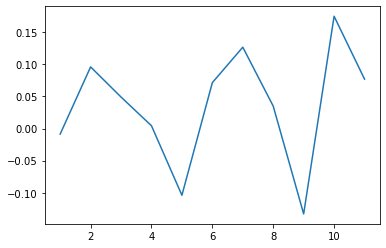

In [118]:
plt.plot(df['text'],df['val'])

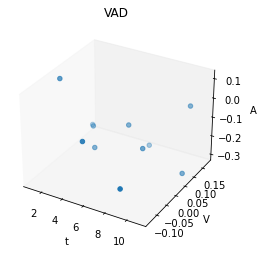

In [127]:
fig = plt.figure(size=[10,10])
ax = fig.add_subplot(111, projection='3d')
#ax.plot(df['val'],df['aro'],df['dom'])
ax.scatter(df['text'],df['val'],df['aro'])
ax.set_title("VAD")
ax.set_xlabel("t")
ax.set_ylabel("V")
ax.set_zlabel("A")
ax.grid(False)
plt.show()

In [133]:
df1 = pd.read_csv('nom-fichier.csv')

In [137]:
df1

Unnamed: 0                    name genre  \
0               0     Ses01M_impro06_F000     F   
1               1     Ses01M_impro06_M000     M   
2               2     Ses01M_impro06_M001     M   
3               3     Ses01M_impro06_F001     F   
4               4     Ses01M_impro06_M002     M   
...           ...                     ...   ...   
10081       10081  Ses05M_script02_2_M038     M   
10082       10082  Ses05M_script02_2_F037     F   
10083       10083  Ses05M_script02_2_M039     M   
10084       10084  Ses05M_script02_2_F038     F   
10085       10085  Ses05M_script02_2_M040     M   

                                                     phr     time     val  \
0                                              You okay?   2.5845  3.0000   
1                                  Yeah, I'm just-- yeah   4.0467  3.0000   
2                      Just kind of feel numb, you know.   3.7092  3.0000   
3                                       What's happened?   3.1275  3.0000   
4                                  You didn't even hear?   4.3018  2.5000   
...                                                  ...      ...     ...   
10081        Are you still cold?  Still want to go home?   4.6700  3.3333   
10082   No.  I'm beginning to think you might be righ...  13.4800  3.6667   
10083   Shh.  If we're really quiet, the fish might c...   6.6300  4.0000   
10084                                            Or not.   2.0100  3.6667   
10085                                            Or not.   2.3078  4.0000   

          dom     act  emo  
0      2.0000  2.5000  neu  
1      2.0000  2.5000  sad  
2      3.0000  2.0000  sad  
3      2.5000  2.0000  neu  
4      2.0000  2.0000  sad  
...       ...     ...  ...  
10081  2.3333  2.6667  xxx  
10082  2.3333  2.6667  hap  
10083  2.6667  3.0000  xxx  
10084  2.3333  2.6667  hap  
10085  2.0000  2.3333  hap  

[10086 rows x 9 columns]

In [138]:
dt = df1[['phr','val','act','dom']]

In [139]:
dt

phr     val     act  \
0                                              You okay?  3.0000  2.5000   
1                                  Yeah, I'm just-- yeah  3.0000  2.5000   
2                      Just kind of feel numb, you know.  3.0000  2.0000   
3                                       What's happened?  3.0000  2.0000   
4                                  You didn't even hear?  2.5000  2.0000   
...                                                  ...     ...     ...   
10081        Are you still cold?  Still want to go home?  3.3333  2.6667   
10082   No.  I'm beginning to think you might be righ...  3.6667  2.6667   
10083   Shh.  If we're really quiet, the fish might c...  4.0000  3.0000   
10084                                            Or not.  3.6667  2.6667   
10085                                            Or not.  4.0000  2.3333   

          dom  
0      2.0000  
1      2.0000  
2      3.0000  
3      2.5000  
4      2.0000  
...       ...  
10081  2.3333  
10082  2.3333  
10083  2.6667  
10084  2.3333  
10085  2.0000  

[10086 rows x 4 columns]

In [141]:
list(dt['phr'][0:50])

[' You okay?',
 " Yeah, I'm just-- yeah",
 ' Just kind of feel numb, you know.',
 " What's happened?",
 " You didn't even hear?",
 ' [BREATHING] Umm.',
 " God I've told this story so many times. Umm.",
 " You don't have to if you don't want to.",
 ' I just...I just basically lost someone that was really close to me.',
 " And I've kind of been dealing with all of the...the stuff, you know the hospital and people work because...",
 " I'm sorry to hear that.",
 " He kind of didn't have anyone to take care of that for him, so--",
 " You've been taking care of it all?",
 ' Oh Jesus.',
 " It's just really...really messed up.",
 ' He sick for awhile?',
 ' No.',
 ' Just like it.',
 ' Was it an accident?',
 ' No, I mean it just came on really quick, you know I mean it was a [GARBAGE] it was a sickness but it just --',
 ' how was sick?',
 ' What?',
 " Well, I'm confused.  He was sick or it was an accident?",
 ' He was sick. He got sick. He got sick but it happened really, really fast, you know.'

In [147]:
p = list(dt['phr'][0:250]) 
v  = []
a =  []
d = []
for i in p :
    input_id1, attention_mask1 = tokenize_split("I lost my dog yesterday. I eat pasta", tokenizer)
    output1 = model(
                input_ids=input_id1,
                attention_mask=attention_mask1)
    l = list(output1[1].detach().numpy())[0]
    v.append( l[0])
    a.append( l[1])
    d.append( l[2])
data = {'text':p, 'val': v,'aro' :a , 'dom':d}
dl = pd.DataFrame(data)
dl['emo'] = df1['emo'][0:250]
dlm = df1[['phr','val','act','dom','emo']][0:250]

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [148]:
dl.to_csv('model_data.csv')
dlm.to_csv('model_dat.csv')

In [153]:
dlm

phr  val  act  dom  emo
0                                            You okay?  3.0  2.5  2.0  neu
1                                Yeah, I'm just-- yeah  3.0  2.5  2.0  sad
2                    Just kind of feel numb, you know.  3.0  2.0  3.0  sad
3                                     What's happened?  3.0  2.0  2.5  neu
4                                You didn't even hear?  2.5  2.0  2.0  sad
..                                                 ...  ...  ...  ...  ...
245   The same applies to you too, except you so mu...  4.0  3.0  3.0  xxx
246    Do you remember that row we did have in Venice?  4.0  2.5  1.5  hap
247                              Which particular one?  4.0  2.5  2.0  hap
248   The one when you put that little wooden paint...  3.5  3.5  3.0  xxx
249   Oh, Charles.  That was his name Charles. He d...  5.0  4.5  3.0  exc

[250 rows x 5 columns]

In [152]:
dl

text       val       aro  \
0                                            You okay?  0.153011 -0.281881   
1                                Yeah, I'm just-- yeah  0.083558 -0.176399   
2                    Just kind of feel numb, you know.  0.181151 -0.110390   
3                                     What's happened?  0.138688 -0.223365   
4                                You didn't even hear?  0.041461 -0.119865   
..                                                 ...       ...       ...   
245   The same applies to you too, except you so mu...  0.042170 -0.185670   
246    Do you remember that row we did have in Venice? -0.014622 -0.194995   
247                              Which particular one?  0.137194 -0.227213   
248   The one when you put that little wooden paint... -0.006959 -0.187686   
249   Oh, Charles.  That was his name Charles. He d...  0.071468 -0.150056   

          dom  emo  
0    0.059136  neu  
1   -0.064885  sad  
2    0.142428  sad  
3    0.158063  neu  
4    0.069477  sad  
..        ...  ...  
245  0.142276  xxx  
246  0.203313  hap  
247  0.229080  hap  
248  0.027766  xxx  
249  0.155509  exc  

[250 rows x 5 columns]